# Forecasting Food Prices in Rwanda
Every time I go to the supermarket, my wallet weeps a little. But how expensive is food around the world? In this project, I will explore time series of food prices in Rwanda from the [United Nations Humanitarian Data Exchange Global Food Price Database](https://data.humdata.org/dataset/wfp-food-prices). Agriculture makes up over 30% of Rwanda's economy, and over 60% of its export earnings [(CIA World Factbook)](https://www.cia.gov/library/publications/the-world-factbook/geos/rw.html), so the price of food is very important to the livelihood of many Rwandans.

In this project, I am going to import, manipulate, visualize and forecast Rwandan potato price data. I will also wrap my analysis into functions to make it easy to analyze prices of other foods.

## 1. Importing important price data

In [22]:
# Load the readr and dplyr packages
library(readr)
library(dplyr)
library(tidyverse)

# Import the potatoes dataset
potato_prices <- read_csv("C:\\Users\\wikie\\Documents\\Datasets\\Rwanda\\potatoes.csv")
# Take a glimpse at the contents
glimpse(potato_prices)

Parsed with column specification:
cols(
  adm0_id = col_double(),
  adm0_name = col_character(),
  adm1_id = col_double(),
  adm1_name = col_character(),
  mkt_id = col_double(),
  mkt_name = col_character(),
  cm_id = col_double(),
  cm_name = col_character(),
  cur_id = col_double(),
  cur_name = col_character(),
  pt_id = col_double(),
  pt_name = col_character(),
  um_id = col_double(),
  um_name = col_character(),
  mp_month = col_double(),
  mp_year = col_double(),
  mp_price = col_double(),
  mp_commoditysource = col_character()
)


Rows: 4,320
Columns: 18
$ adm0_id            <dbl> 205, 205, 205, 205, 205, 205, 205, 205, 205, 205...
$ adm0_name          <chr> "Rwanda", "Rwanda", "Rwanda", "Rwanda", "Rwanda"...
$ adm1_id            <dbl> 21973, 21973, 21973, 21973, 21973, 21973, 21973,...
$ adm1_name          <chr> "$West/Iburengerazuba", "$West/Iburengerazuba", ...
$ mkt_id             <dbl> 1045, 1045, 1045, 1045, 1045, 1045, 1045, 1045, ...
$ mkt_name           <chr> "Birambo", "Birambo", "Birambo", "Birambo", "Bir...
$ cm_id              <dbl> 148, 148, 148, 148, 148, 148, 148, 148, 148, 148...
$ cm_name            <chr> "Potatoes (Irish)", "Potatoes (Irish)", "Potatoe...
$ cur_id             <dbl> 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, ...
$ cur_name           <chr> "RWF", "RWF", "RWF", "RWF", "RWF", "RWF", "RWF",...
$ pt_id              <dbl> 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, ...
$ pt_name            <chr> "Retail", "Retail", "Retail", "Retail", "Retail"...
$ um_id              <dbl> 5

## 2. Once more, with feeling
Many of the columns in the potato data aren't very useful for our analysis. For example, the adm1_name column is always "Rwanda", and cur_name is always "RWF". (This is short for Rwandan Franc; for context, 1000 RWF is a little over 1 USD.) Similarly, we don't really need any of the ID columns or the data source.

Even the columns we do need have slightly obscure names. For example, adm1_id isn't as clear as region, and mkt_name isn't as clear as market. One of the most types of data analysis disaster is to misunderstand what a variable means, so naming variable clearly is a useful way to avoid this. One trick is that any variable that includes a unit should include that unit in the variable name. Here, the prices are given in Rwandan Francs, so price_rwf is a good name.

In [17]:
# Import again, only reading specific columns
potato_prices <- read_csv("C:\\Users\\wikie\\Documents\\Datasets\\Rwanda\\potatoes.csv", 
                          col_types=cols_only(adm1_name='c', 
                                              mkt_name='c', 
                                              cm_name='c', 
                                              mp_month='i', 
                                              mp_year='i', 
                                              mp_price='d'))

In [19]:
# Rename the columns to be more informative
potato_prices_renamed <- rename(potato_prices, region = adm1_name,
                                                market = mkt_name,
                                                commodity_kg = cm_name,
                                                month = mp_month,
                                                year = mp_year,
                                                price_rwf = mp_price)

In [20]:
# Check the result
glimpse(potato_prices_renamed)

Rows: 4,320
Columns: 6
$ region       <chr> "$West/Iburengerazuba", "$West/Iburengerazuba", "$West...
$ market       <chr> "Birambo", "Birambo", "Birambo", "Birambo", "Birambo",...
$ commodity_kg <chr> "Potatoes (Irish)", "Potatoes (Irish)", "Potatoes (Iri...
$ month        <int> 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3...
$ year         <int> 2010, 2010, 2011, 2011, 2011, 2011, 2011, 2011, 2011, ...
$ price_rwf    <dbl> 157.0000, 133.3333, 96.5000, 97.0000, 107.8000, 125.50...


## 3. Spring cleaning
As is often the case in a data analysis, the data we are given isn’t in quite the form we’d like it to be. For example, in the last task the month and year were given as integers. Since we’ll be performing some time series analysis, it would be helpful if they were provided as dates. Before we can analyze the data, we need to spring clean it.

In [23]:
# Load lubridate
library(lubridate)

Warning message:
"package 'lubridate' was built under R version 3.6.3"
Attaching package: 'lubridate'

The following objects are masked from 'package:base':

    date, intersect, setdiff, union



In [24]:
# Convert year and month to Date
potato_prices_cleaned <- potato_prices_renamed %>%
       mutate(date = ymd(paste(year, month, "01"))) %>%
       select(-month, -year) # increasing, start from the oldest data

# See the result
glimpse(potato_prices_cleaned)

Rows: 4,320
Columns: 5
$ region       <chr> "$West/Iburengerazuba", "$West/Iburengerazuba", "$West...
$ market       <chr> "Birambo", "Birambo", "Birambo", "Birambo", "Birambo",...
$ commodity_kg <chr> "Potatoes (Irish)", "Potatoes (Irish)", "Potatoes (Iri...
$ price_rwf    <dbl> 157.0000, 133.3333, 96.5000, 97.0000, 107.8000, 125.50...
$ date         <date> 2010-11-01, 2010-12-01, 2011-01-01, 2011-02-01, 2011-...


## 4. Potatoes are not a balanced diet
As versatile as potatoes are, with their ability to be boiled, roasted, mashed, fried, or chipped (nom.. nom.. nom.. fyi, mashed is my fave), they say the people of Rwanda have more varied culinary tastes. I’d like to try Rwandan food someday!

If we want to do a similar task many times, we could just cut and paste our code and change bits here and there. This is a terrible idea, since changing code in one place doesn’t keep it up to date in the other places, and we quickly end up with lots of bugs. Soooo, I’d like to write a function. That way I avoid cut and paste errors and can have more readable code.

In [26]:
# Wrap this code into a function

read_price_data <- function(commodity) {
    prices <- read_csv((paste("C:\\Users\\wikie\\Documents\\Datasets\\Rwanda\\", commodity, ".csv", sep = "")),
  col_types = cols_only(
    adm1_name = col_character(),
    mkt_name = col_character(),
    cm_name = col_character(),
    mp_month = col_integer(),
    mp_year = col_integer(),
    mp_price = col_double()
  )
)

prices_renamed <- prices %>% 
  rename(
    region = adm1_name, 
    market = mkt_name,
    commodity_kg = cm_name,
    month = mp_month,
    year = mp_year,
    price_rwf = mp_price
  )

prices_cleaned <- prices_renamed %>% 
  mutate(
    date = ymd(paste(year, month, "01"))
  ) %>% 
  select(-month, -year)
}

# Test it
pea_prices <- read_price_data("Peas")


In [27]:
glimpse(pea_prices)

Rows: 1,893
Columns: 5
$ region       <chr> "$West/Iburengerazuba", "$West/Iburengerazuba", "$West...
$ market       <chr> "Birambo", "Birambo", "Birambo", "Birambo", "Birambo",...
$ commodity_kg <chr> "Peas (fresh)", "Peas (fresh)", "Peas (fresh)", "Peas ...
$ price_rwf    <dbl> 403.5000, 380.0000, 277.5000, 450.0000, 450.0000, 375....
$ date         <date> 2011-01-01, 2011-02-01, 2011-04-01, 2011-05-01, 2011-...


## 5. Plotting the price of potatoes
A great first step in any data analysis is to look at the data. In this case, we have some prices, and we have some dates, so the obvious thing to do is to see how those prices change over time.



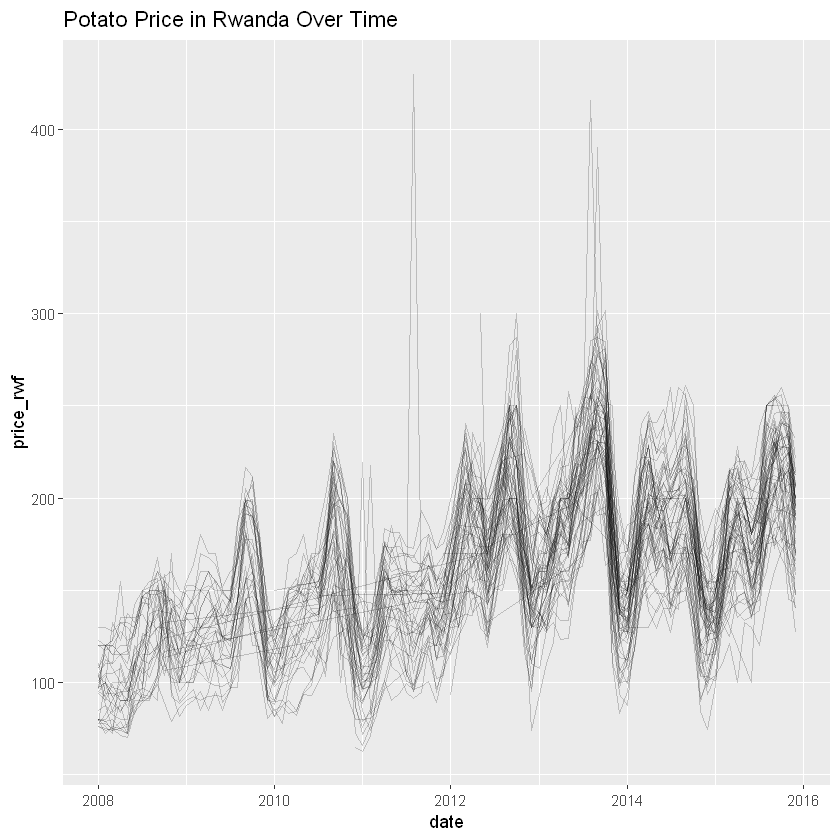

In [28]:
# Load ggplot2
library(ggplot2)

# Draw a line plot of price vs. date grouped by market 
ggplot(potato_prices_cleaned, aes(x = date, y = price_rwf, group = market)) +
geom_line(alpha = 0.2) +
ggtitle("Potato Price in Rwanda Over Time")

## 6. What a lotta plots
There is a bit of a trend in the potato prices, with them increasing until 2013, after which they level off. More striking though is the seasonality: the prices are lowest around December and January, and have a peak around August. Some years also show a second peak around April or May.

Just as with the importing and cleaning code, if we want to make lots of similar plots, we need to wrap the plotting code into a function.

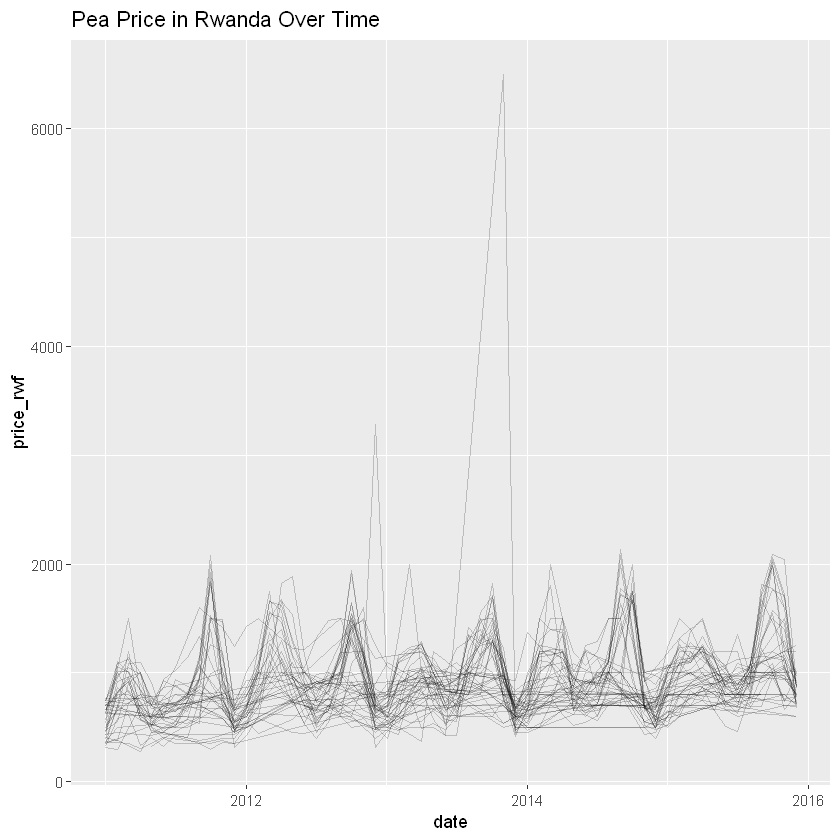

In [29]:
# Wrap this code into a function
plot_price_vs_time <- function(prices, commodity) {
    prices %>%
    ggplot(aes(date, price_rwf, group = market)) +
    geom_line(alpha = 0.2) +
    ggtitle(paste(commodity, "Price in Rwanda Over Time", sep = " "))
}

# Try the function on the pea data
plot_price_vs_time(pea_prices, "Pea") 

## 7. Preparing to predict the future (part 1)
While it’s useful to see how the prices have changed in the past, what’s more exciting is to forecast how they will change in the future. Before we get to that, there are some data preparation steps that need to be performed.

The datasets for each commodity are very rich: rather than being a single time series, they consist of a time series for each market. The fancy way of analyzing these is to treat them as a single hierarchical time series. The easier way, that we’ll try here, is to take the average price across markets at each time and analyze the resulting single time series.

Looking at the plots from the potato and pea datasets, we can see that occasionally there is a big spike in the price. That probably indicates a logistic problem where that food wasn’t easily available at a particular market, or the buyer looked like a tourist and got ripped off. The consequence of these outliers is that it is a bad idea to use the mean price of each time point: instead, the median makes more sense since it is robust against outliers.

In [30]:
# Group by date, and calculate the median price
potato_prices_summarized <- potato_prices_cleaned %>%
group_by(date) %>%
summarize(median_price_rwf = median(price_rwf))

# See the result
glimpse(potato_prices_summarized)

`summarise()` ungrouping output (override with `.groups` argument)


Rows: 96
Columns: 2
$ date             <date> 2008-01-01, 2008-02-01, 2008-03-01, 2008-04-01, 2...
$ median_price_rwf <dbl> 97.5000, 100.0000, 95.0000, 96.2500, 95.0000, 110....


## 8. Preparing to predict the future (part 2)
Time series analysis in R is at a crossroads. The best and most mature tools for analysis are based around a time series data type called ts, which predates the tidyverse by several decades. That means that we have to do one more data preparation step before we can start forecasting: we need to convert our summarized dataset into a ts object.

In [31]:
# Load magrittr
library(magrittr)

# Extract a time series
potato_time_series <- potato_prices_summarized %$% 
ts(median_price_rwf, 
   start = c(year(min(date)), month(min(date))), 
   end = c(year(max(date)), month(max(date))),
   frequency = 12)
   
# See the result
potato_time_series

Warning message:
"package 'magrittr' was built under R version 3.6.3"
Attaching package: 'magrittr'

The following object is masked from 'package:purrr':

    set_names

The following object is masked from 'package:tidyr':

    extract

ERROR while rich displaying an object: Error in repr_matrix_generic(obj, "\n%s%s\n", sprintf("|%%s\n|%s|\n", : formal argument "cols" matched by multiple actual arguments

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
2008,97.5000,100.0000,95.0000,96.2500,95.0000,110.0000,116.6667,125.0000,136.2500,130.0000,127.5000,114.3750
2009,120.0000,122.5000,130.0000,131.2500,135.0000,124.3125,125.8333,144.2500,181.2500,170.0000,150.2500,112.0000
2010,109.6875,113.5000,131.2500,132.0833,140.4167,147.3750,142.5000,161.5000,182.4000,162.5000,151.5000,122.5000
2011,105.7000,108.1750,118.8750,145.0143,148.6667,148.0500,137.4048,137.2619,141.6667,144.2000,133.1750,141.5000
2012,150.7500,175.2500,186.0139,186.2500,182.5000,162.7500,179.1250,196.9643,226.5000,203.5000,169.2500,144.0000
2013,154.3333,157.0000,171.2500,187.5000,177.0000,202.2500,210.0000,233.1875,241.3333,237.5000,176.7083,140.0000
2014,138.3333,158.7500,186.2500,198.2500,191.0000,189.3333,182.5000,187.6191,200.0000,183.1309,150.0000,133.9286
2015,136.2500,157.6071,178.0000,190.2778,179.3750,168.3333,180.0000,202.1250,223.5000,217.5000,216.1250,190.0000


## 9. Another day, another function to write
Those data preparation steps were tricky! Wouldn’t it be really nice if we never had to write them again? Well, if we wrap that code into a function, then we won’t have to.

In [32]:
# Wrap this code into a function
create_price_time_series <- function(price_data) {
    prices_summarized <- price_data %>%
  group_by(date) %>% 
  summarize(median_price_rwf = median(price_rwf))

time_series <- prices_summarized %$% 
  ts(
    median_price_rwf, 
    start = c(year(min(date)), month(min(date))), 
    end   = c(year(max(date)), month(max(date))), 
    frequency = 12
  )
}

# Try the function on the pea data
pea_time_series <- create_price_time_series(pea_prices)
pea_time_series

`summarise()` ungrouping output (override with `.groups` argument)
ERROR while rich displaying an object: Error in repr_matrix_generic(obj, "\n%s%s\n", sprintf("|%%s\n|%s|\n", : formal argument "cols" matched by multiple actual arguments

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         retur

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
2011,561.6667,700.0000,958.0000,710.0000,591.5000,597.8572,666.3572,758.5000,938.8333,1506.2500,787.5000,548.9375
2012,655.0000,950.0000,1272.1667,1166.0000,945.8750,822.3333,714.2857,788.1250,990.7222,1413.7500,964.2619,661.8571
2013,668.7500,781.6334,829.9875,975.0000,908.2500,789.9444,806.8000,1000.0000,1162.4583,1316.7500,916.6667,623.8571
2014,695.5000,1025.0000,1166.6250,1083.2500,825.0000,816.6667,809.5714,1000.0000,1000.0000,1666.6667,700.0000,633.3333
2015,800.0000,1066.6667,1100.0000,1051.8889,950.0000,873.6667,804.1250,900.0000,1166.6667,1550.0000,1066.6667,802.1250


## 10. The future of potato prices
All the preparation is done and we are ready to start forecasting. One question we might ask is “how do I know if I can trust our forecast?”. Recall that both the potato and the pea data had strong seasonality (for example, potatoes were most expensive around August and cheapest around December). For agricultural data, a good forecast should show a similar shape throughout the seasons.

Now then, are we ready to see the future?

In [37]:
# Load forecast
library(forecast)

# Forecast the potato time series
potato_price_forecast <- forecast(potato_time_series)

# View it
potato_price_forecast

Warning message:
"package 'forecast' was built under R version 3.6.3"Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


         Point Forecast     Lo 80    Hi 80     Lo 95    Hi 95
Jan 2016       190.0093 171.35706 208.6615 161.48317 218.5354
Feb 2016       202.6099 174.14582 231.0740 159.07783 246.1420
Mar 2016       220.0317 181.72222 258.3413 161.44238 278.6211
Apr 2016       231.5932 184.48380 278.7026 159.54559 303.6408
May 2016       226.2626 174.20438 278.3209 146.64641 305.8789
Jun 2016       229.1587 170.73454 287.5829 139.80665 318.5108
Jul 2016       230.8787 166.57270 295.1848 132.53113 329.2263
Aug 2016       251.1739 175.53815 326.8096 135.49902 366.8487
Sep 2016       279.3573 189.13187 369.5827 141.36943 417.3451
Oct 2016       262.7887 172.33073 353.2467 124.44516 401.1323
Nov 2016       236.0485 149.89274 322.2042 104.28465 367.8123
Dec 2016       205.0924 126.05584 284.1290  84.21640 325.9684
Jan 2017       205.0036 121.88813 288.1190  77.88948 332.1177
Feb 2017       218.4941 125.58323 311.4050  76.39917 360.5891
Mar 2017       237.1698 131.67270 342.6669  75.82591 398.5137
Apr 2017

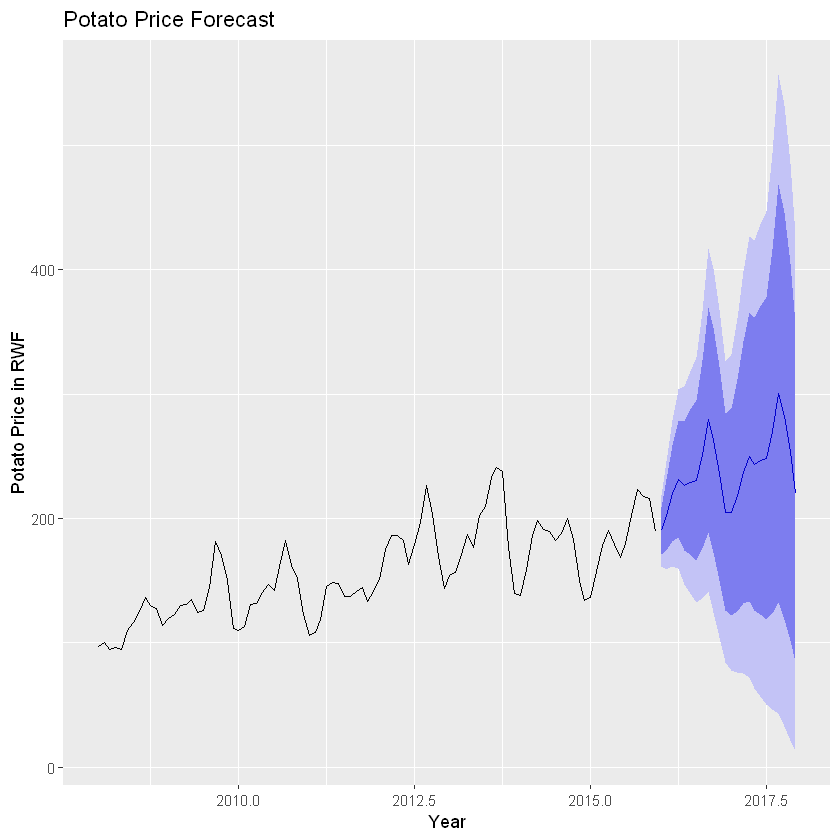

In [38]:
# Plot the forecast
autoplot(potato_price_forecast, 
         main = "Potato Price Forecast",
         xlab = "Year",
         ylab = "Potato Price in RWF")

## 11. The final function
Nice! The forecast shows the spike in potato prices in late summer and the dip toward the end of the year.

With this analysis step, just as the previous steps, to make things repeatable, we need to wrap the code into a function.

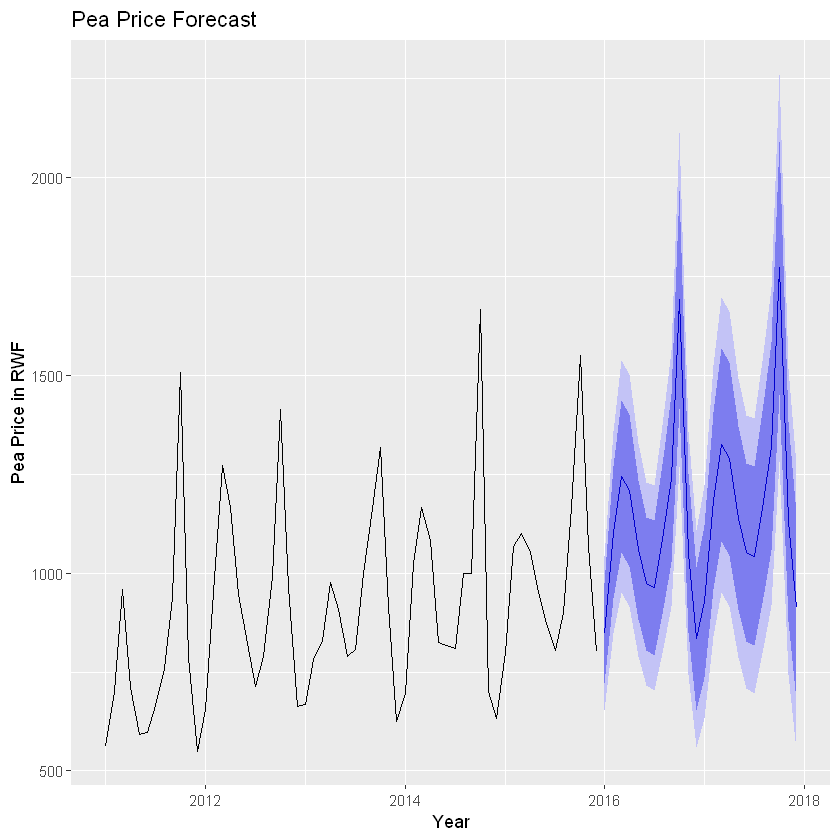

In [39]:
# Wrap the code into a function
plot_price_forecast <- function(time_series, commodity) {
    price_forecast <- forecast(time_series)
    autoplot(price_forecast, 
             main = paste(commodity, "Price Forecast", sep = " "),
             xlab = "Year",
             ylab = paste(commodity, "Price in RWF", sep = " "))
    }

# Try the function on the pea data
plot_price_forecast(pea_time_series, "Pea")

From here, we can forecast that the price for pea in January 2016 is around RWF 1000 and RWF 1750 in October 2017.

## 12. Do it all over again
That was a lot of effort writing all that code to analyze the potato data. Fortunately, since we wrapped all the code into functions, we can easily take a look at any other food type.

In [40]:
# Choose dry beans as the commodity
commodity <- "Beans"

# Read the price data
bean_prices <- read_price_data("Beans")

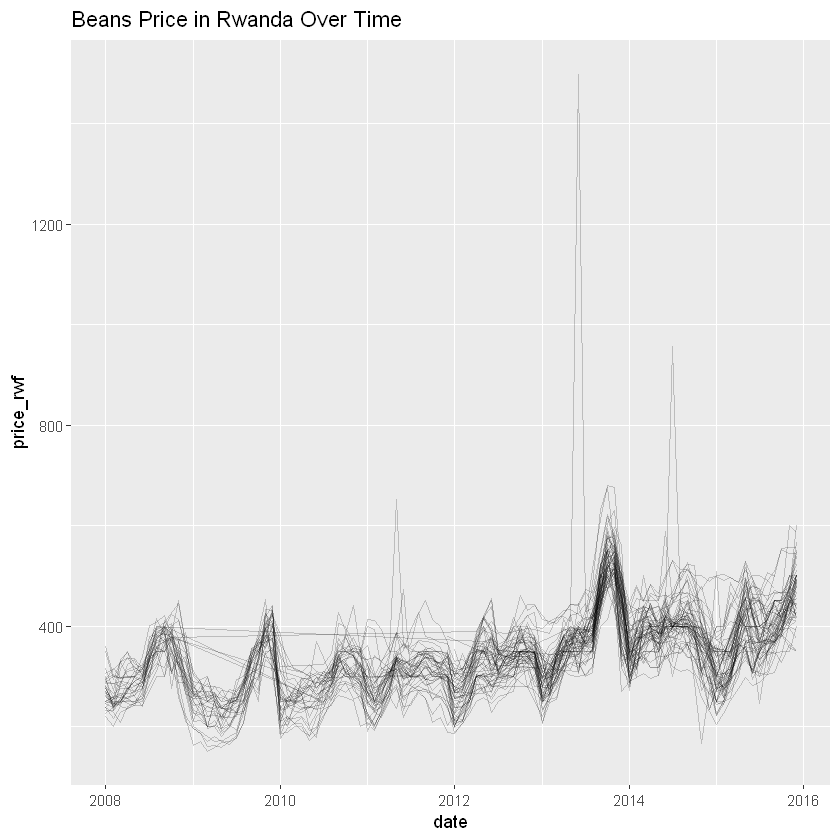

In [41]:
# Plot price vs. time
plot_price_vs_time(bean_prices, "Beans")

`summarise()` ungrouping output (override with `.groups` argument)


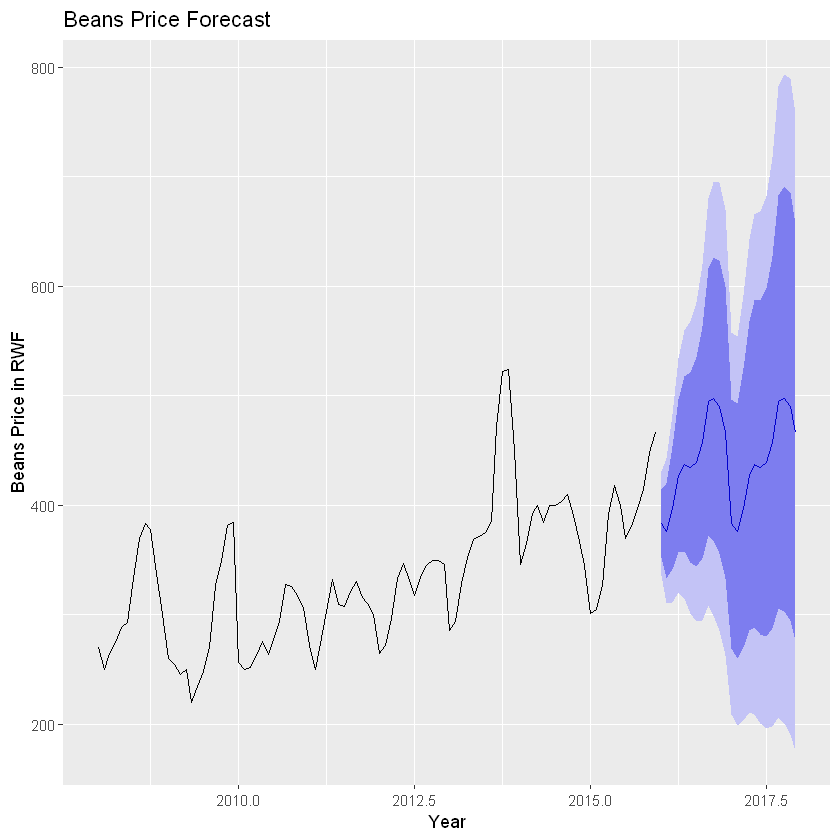

In [42]:
# Create a price time series
bean_time_series <- create_price_time_series(bean_prices)

# Plot the price forecast
plot_price_forecast(bean_time_series, "Beans")

From here, we can forecast that the price for beans in January 2017 is around RWF 380 and RWF 480 in October 2017.